# Project 4
## Group members
- Harmen de Beurs (S4134524)
- Agne Danilaite (S4273702)
- Andzej Gedzo (S4074580)
- Nicolò Montalti (S4947231)

## Initial setup

In [ ]:
import pandas as pd                                             # dataframes
import numpy as np                                              # arrays

from sklearn.model_selection import train_test_split            # split data in test and train set
from sklearn import neighbors, tree, neural_network, ensemble   # machine learning models
from sklearn import base                                        # scikit learn base classes

import requests                                                 # HTTP download
from six import StringIO                                        # strings editing

from matplotlib import pyplot as plt                            # plotting
import seaborn as sn                                            # plotting correlation matrix

from IPython.core.display import Image                          # ...for displaying images in notebook, used for decision tree pictures
from six import StringIO                                        # write string buffers as files, used for making decision tree pictures
import re                                                       # regular expression operations, needed for making decision tree pictures
import VisualizeNN as VisNN                                     # MLP network visualization, requires corresponding python code:
                                                                # http://www.jzliu.net/blog/simple-python-library-visualize-neural-network/

In [ ]:
def getDataset(url):
  '''
  Download a dataset from the web. Given a url with a csv file, returns a pandas dataframe.
  
  Parameters:
  -----------
  url: (str) url where the dataset is located

  Return:
  --------
  dataset: (pd dataframe) dataset in the form of a pandas dataframe
  '''
  
  s=requests.get(url).content
  dataset = pd.read_csv(StringIO(s.decode('utf-8')))
  return dataset

neutron_url = 'https://drive.google.com/uc?export=download&id=1bY6ZPF3WLxfviYSSViuw1SEx1_sWxP46'
gamma_url = 'https://drive.google.com/uc?export=download&id=1TvbbCV-kJeNMuIORMyiMFgH_u_CQSZhX'

In [ ]:
gamma_dataframe = getDataset(gamma_url)
neutron_dataframe = getDataset(neutron_url)

## Dataset analysis

We look at the mean values and standard deviations of the parameters of the two datasets to try to understand which parameters can help us the most in our analysis.

In [ ]:
gamma_description = gamma_dataframe.describe()
gamma_description

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
count,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,43360.000000,4.336000e+04,43360.000000
mean,80.749479,-0.410604,2.902359,19.744211,1.022163,1.967300,0.716676,0.963544,0.968002,2.808279e-03,0.482873
std,46.762866,103.996747,1.179884,5.893862,0.154851,0.900559,0.140513,0.036491,0.023344,4.033629e-03,0.244087
min,0.595195,-179.986000,0.025090,1.000000,1.000000,0.014021,0.224754,0.436667,0.350785,1.054230e-50,0.000000
25%,40.473675,-90.818675,1.905425,16.000000,1.000000,1.232017,0.620547,0.960356,0.966239,1.281237e-03,0.288124
50%,79.210700,-0.410285,2.895825,20.000000,1.000000,1.882490,0.754330,0.968749,0.972596,2.097985e-03,0.384048
75%,119.839750,88.966775,3.916097,24.000000,1.000000,2.640420,0.826166,0.976497,0.977766,3.251785e-03,0.700759
max,163.211000,179.958000,5.234740,47.000000,6.000000,4.369720,1.000000,1.000000,1.000000,3.341460e-01,0.996175


In [ ]:
neutron_description = neutron_dataframe.describe()
neutron_description

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom
count,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000,43512.000000
mean,78.625170,0.705105,0.760000,13.929376,1.122564,0.341868,0.612911,0.893528,0.809153,0.034600,0.769180
std,47.212387,103.985196,0.502411,8.012129,0.381821,0.229777,0.176559,0.101082,0.209241,0.056912,0.276143
min,0.499105,-180.001000,0.024076,1.000000,1.000000,0.006992,0.171400,0.356098,0.000000,0.000000,0.000000
25%,37.196675,-89.329050,0.366767,8.000000,1.000000,0.168263,0.477409,0.838244,0.780414,0.007268,0.649031
50%,76.319900,1.788705,0.666409,13.000000,1.000000,0.299559,0.595015,0.916344,0.879204,0.016139,0.899504
75%,118.370000,90.577475,1.054273,19.000000,1.000000,0.467398,0.735480,0.976849,0.934041,0.034914,0.973680
max,178.647000,180.000000,3.832530,60.000000,6.000000,2.533030,1.000000,1.000000,1.000000,0.779841,0.999937


The parameters we are interested in are the ones which are more different from one dataset to the other. For example we can see that the mean energy of the photons is much greater than the energy of the neutron. On the opposite, the angles do not seem to convey much information since they both range from the same minimum to the same maximum value, with mean 0. To apply this criterion more accurately, we can study the difference between the mean values normalized by the standard deviation. For the total standard deviation we combine the single variances. We can then study the variable
$$
\left| \frac{\mu_1 - \mu_2}{\sqrt{\sigma_1^2 + \sigma_2^2}} \right|
$$
The bigger this variable is, the more the parameter is relevant to our analysis.

In [ ]:
pars = abs(neutron_description.loc['mean'] - gamma_description.loc['mean']) / (neutron_description.loc['std']**2 + gamma_description.loc['std']**2)**0.5
pars.sort_values(ascending=False)

E1         1.748885
E          1.670589
LatMom     0.776835
Z20        0.754483
E9E25      0.651518
NrHits     0.584614
Z53        0.557208
E1E9       0.459853
NrBumps    0.243675
Th         0.031968
Ph         0.007586
dtype: float64

We can see that the six most relevant parameters are $E_1, E, Z_{20}, E_9E_{25}$, LatMom and NrHits. However, some of this parameters may convey the same information twice. If this is the case, using only one parameter would convey the same information with less chance of overfitting our model. Thus, it is a good idea to study the correlation matrix of the parameters.

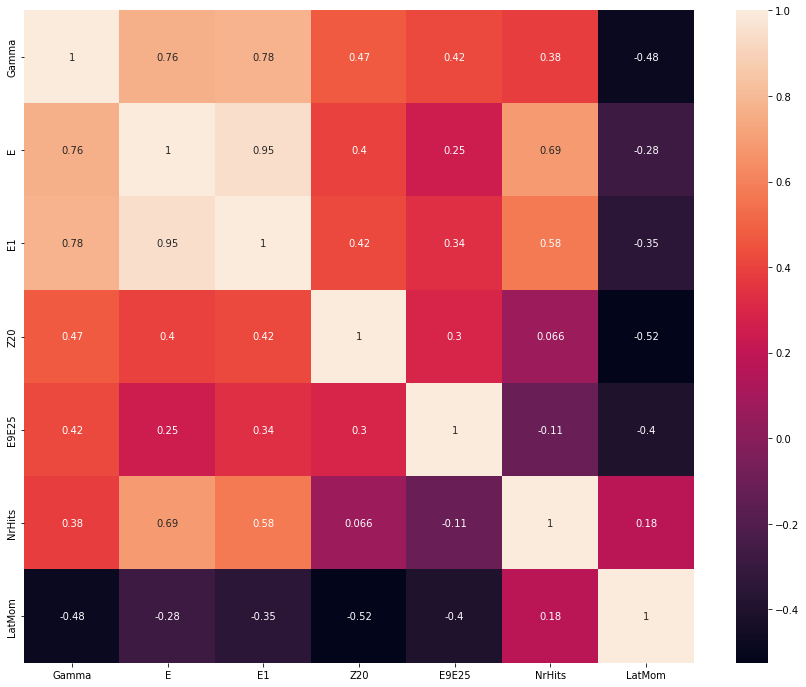

In [ ]:
# creating a new column 'Gamma' in the dataframe. The value is set to 1
# if the particle is a photon and 0 if it is a neutron
neutron_dataframe['Gamma'] = 0
gamma_dataframe['Gamma'] = 1
dataframe = pd.concat([neutron_dataframe, gamma_dataframe])

correlation_matrix = dataframe[['Gamma', 'E', 'E1', 'Z20', 'E9E25', 'NrHits', 'LatMom']].corr()

plt.figure(figsize=(15, 12))
sn.heatmap(correlation_matrix, annot=True)
plt.show()

We immediately notice than there is a high correlation between $E$ and $E_1$ and between $E$ and NrHits.

### Normalization

We add a new set of normalized features to the dataset. The normalized features have all mean 0 and standard deviation 1. They are particularly useful in models like KNN or DNN.

In [ ]:
# splitting features (X) and labels (y)
y_data = dataframe['Gamma']
X_data = dataframe.drop('Gamma', axis=1)

# normalization
X_data_norm = (X_data - X_data.mean()) / X_data.std()
X_data_norm.columns = [col + '_norm' for col in X_data_norm.columns]

dataframe = pd.concat([dataframe, X_data_norm], axis=1)
dataframe.describe()

,Th,Ph,E,NrHits,NrBumps,E1,E1E9,E9E25,Z20,Z53,LatMom,Gamma,Th_norm,Ph_norm,E_norm,NrHits_norm,NrBumps_norm,E1_norm,E1E9_norm,E9E25_norm,Z20_norm,Z53_norm,LatMom_norm
count,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,86872.000000,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04,8.687200e+04
mean,79.685466,0.148227,1.829305,16.831706,1.072451,1.153162,0.664703,0.928475,0.888439,0.018732,0.626277,0.499125,-1.550104e-14,2.429731e-17,-9.034160e-15,5.469011e-15,-9.224749e-14,6.358258e-15,-1.874491e-14,1.177822e-13,-2.420753e-14,7.930154e-16,-4.216935e-14
std,47.000290,103.991860,1.403104,7.612113,0.295819,1.044867,0.167809,0.083713,0.168847,0.043395,0.297361,0.500002,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.499105,-180.001000,0.024076,1.000000,1.000000,0.006992,0.171400,0.356098,0.000000,0.000000,0.000000,0.000000,-1.684806e+00,-1.732340e+00,-1.286597e+00,-2.079805e+00,-2.449180e-01,-1.096953e+00,-2.939660e+00,-6.837385e+00,-5.261811e+00,-4.316605e-01,-2.106116e+00
25%,38.653650,-89.965025,0.649015,11.000000,1.000000,0.294016,0.530591,0.908604,0.874595,0.001861,0.334035,0.000000,-8.730120e-01,-8.665414e-01,-8.411998e-01,-7.661088e-01,-2.449180e-01,-8.222542e-01,-7.991873e-01,-2.373639e-01,-8.198620e-02,-3.887732e-01,-9.827855e-01
50%,77.745400,0.708017,1.389615,17.000000,1.000000,0.738280,0.678145,0.962716,0.960193,0.004184,0.679864,0.000000,-4.127774e-02,5.383018e-03,-3.133699e-01,2.210866e-02,-2.449180e-01,-3.970665e-01,8.010463e-02,4.090304e-01,4.249652e-01,-3.352453e-01,1.802094e-01
75%,119.245000,89.746075,2.896270,22.000000,1.000000,1.880318,0.804436,0.976549,0.974134,0.016598,0.923037,1.000000,8.416870e-01,8.615852e-01,7.604318e-01,6.789565e-01,-2.449180e-01,6.959312e-01,8.326903e-01,5.742739e-01,5.075343e-01,-4.918080e-02,9.979782e-01
max,178.647000,180.000000,5.234740,60.000000,6.000000,4.369720,1.000000,1.000000,1.000000,0.779841,0.999937,1.000000,2.105552e+00,1.729479e+00,2.427073e+00,5.671000e+00,1.665730e+01,3.078438e+00,1.998084e+00,8.544101e-01,6.607266e-01,1.753927e+01,1.256588e+00


From the *mean* and *std* rows, we can see that the features have been correctly normalized.

### Visualization

Let's now visulalize the features correlation plots.

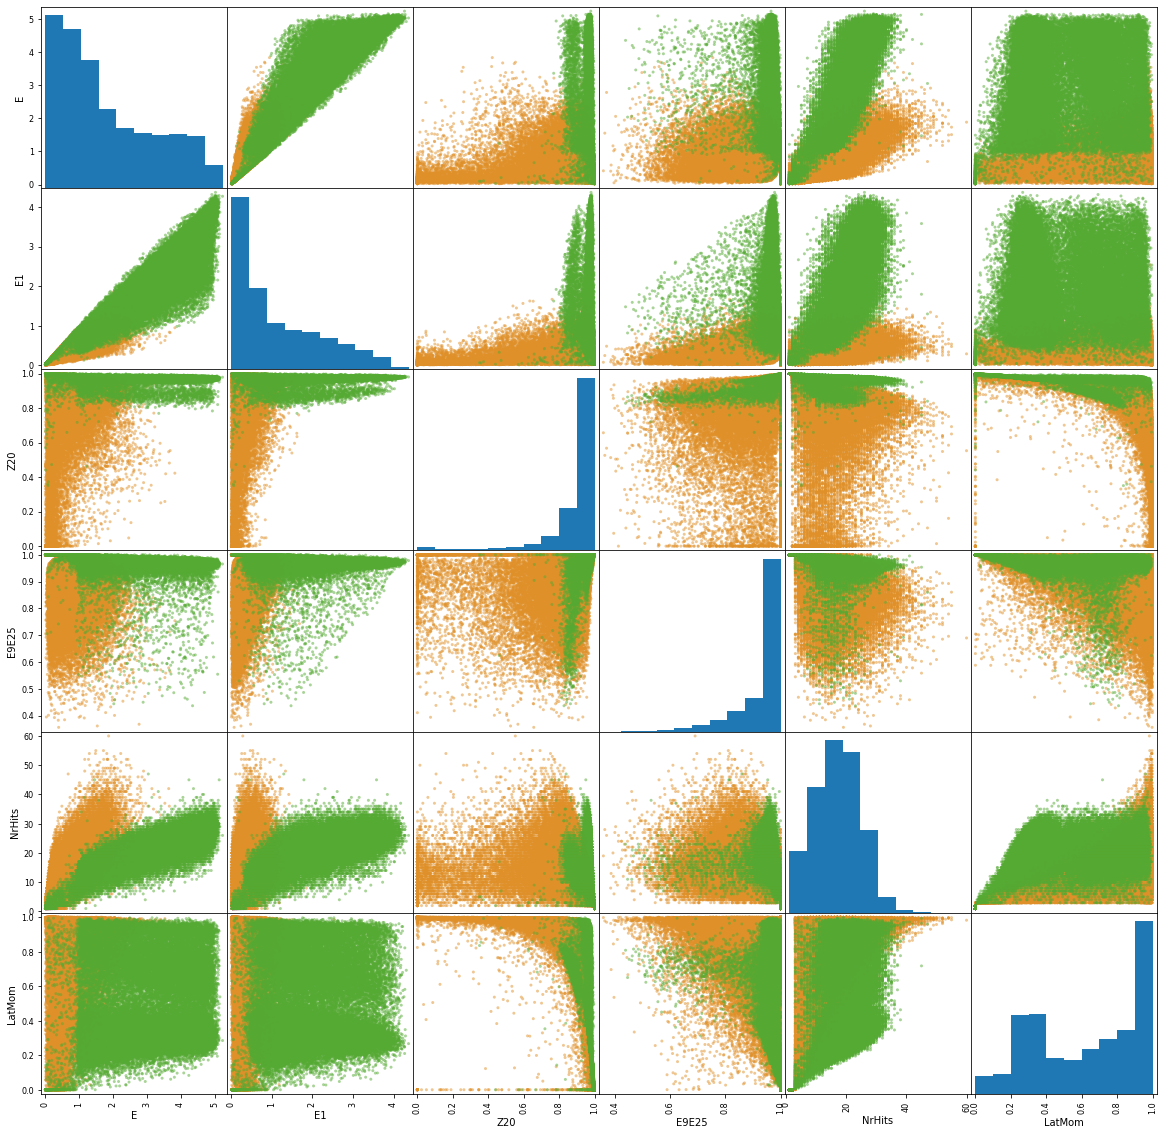

In [ ]:
colors = ['#e09028', '#55aa33']     # orange for neutrons and green for photons
_ = pd.plotting.scatter_matrix(X_data[['E', 'E1', 'Z20', 'E9E25', 'NrHits', 'LatMom']], figsize=(20,20), color=[colors[x] for x in list(y_data)])

As we expected, all parameters performs well in splitting the data in two cluster. The only exception is the couple ($E$, $E_1$) and (NrHits, LatMom). The first couple is hardly surprising since we already knew from the correlation matrix that they were strongly correlated. We should not use both this parameters in our models. The second couple did not seem correlated from the previous analysis, but we have to keep in mind that the information conveyed by LatMom could be redundant.

## Train, validation and test set
Before going over we have to split our data. We are going to use three sets of data: train, validation and test. The train set is used to train the models and the validation set is used to evaluate the quality of the models during the training. This way we can tune the hyperparameters of the models to get the best possible result. When we have found the best hyperparameters, we train the model both on the train and validation sets. Finally we test the model on the test set. The test set is never used during the training to be sure we do not overfit the model, not even tuning the hyperparameters.

We shall use 20% of the data as train set. The rest of the data is split in half for training and validation. This second split is done in the fitData function (defined later).



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataframe.drop('Gamma', axis=1), dataframe['Gamma'], shuffle=True, test_size=0.2)
train_dataframe = pd.concat([X_train, y_train], axis=1)
test_dataframe = pd.concat([X_test, y_test], axis=1)

## FOM
The quality of our models is evaluated using the figure of merit (FOM).

In [ ]:
def FOM(prediction, reality):
  '''
  Compute the FOM (figure of merit) of a prediction.

  Parameters:
  -----------
  prediction: (N array) predicted values (1 if photon and 0 if neutron)
  reality: (N array) real values (1 if photon and 0 if neutron). Must have the same size of prediction

  Returns:
  --------
  FOM: (float) figure of merit
  '''
  assert len(prediction) == len(reality)

  signal = np.sum((prediction + reality) == 2)       # number of correctly identified photons
  background = np.sum(prediction) - signal           # number of neutrons identified as photon  
  return signal / np.sqrt(signal + background)

Before starting to train our models, it useful to compute the FOM in some simple cases. This will help us to evaluate the quality of our models. We can compute the fom in three cases:
- worst case scenario: we randomly decide if a particle is a photon or a neutron
- simple analysis: we identify a particle as a photon if its energy is greater than ($\overline{E}_{\gamma} + \overline{E}_n) / 2$
- perfect scenario: all the photons are identified and no neutron is selected

In [ ]:
# Split the data in train and test. Since the FOM depends on the number of classified particles,
# we have to use a set of the same size of the one we will use to train and test our models.
# We then split the data in a train and a validation set of equal dimensions
X_train, X_val, y_train, y_val = train_test_split(train_dataframe.drop('Gamma', axis=1), train_dataframe['Gamma'], test_size=0.5, shuffle=True)
X_test = test_dataframe.drop('Gamma', axis=1)
y_test = test_dataframe['Gamma']

# randomly predict the type of particle
def randomFOM(X, y):
  random_selection = np.random.randint(0, 2, len(X))
  random_fom = FOM(random_selection, y)
  return random_fom

# simple prediction
def simpleFOM(X, y):
  mean_gamma_energy = gamma_dataframe.E.mean()
  mean_neutron_energy = neutron_dataframe.E.mean()
  energy_threshold = (mean_gamma_energy + mean_neutron_energy) / 2
  simple_selection = np.array(X['E'] > energy_threshold)
  simple_fom = FOM(simple_selection, y)
  return simple_fom

# perfect prediction (all and only photons are correctly classified)
def perfectFOM(X, y):
  perfect_fom = FOM(y, y)
  return perfect_fom

Xs = [X_train, X_val, X_test]
ys = [y_train, y_val, y_test]
labels = ['Train', 'Validation', 'Test']

for X, y, label in zip(Xs, ys, labels):
  random_fom = randomFOM(X, y)
  simple_fom = simpleFOM(X, y)
  perfect_fom = perfectFOM(X, y)

  print(label)
  print(' Random selection: ', random_fom, '\n',
        'Simple selection: ', simple_fom, '\n',
        'Perfect selection: ', perfect_fom)
  print()

perfect_train_fom = perfectFOM(X_train, y_train)
perfect_test_fom = perfectFOM(X_test, y_test)

Train
 Random selection:  65.31315124744171 
 Simple selection:  112.2461408405341 
 Perfect selection:  131.3849306427491

Validation
 Random selection:  65.32509525391669 
 Simple selection:  113.43061219059145 
 Perfect selection:  131.85977400253648

Test
 Random selection:  46.91623774449344 
 Simple selection:  80.11740775841115 
 Perfect selection:  93.33273809334001



We can analyze the result for the test set, an analogous analysis is valid for the other sets. Every model which returns a FOM smaller than 47 performs worse than a random model. The simplest non-random model we have come up with returns a FOM of 80. A perfect model would result in a FOM of 94. We should aim to FOMs greater than 80 and as close as possible to 94. Models which made predictions with FOMs between 47 and 80, even if they work, should be avoided since a better and simpler model exists.

We can notice that, even if the validation and train set have the same dimension, the FOMs are different. This is not surprising since the data are randomly shuffled. We have to keep this in mind when we analyse the final result.

## Functions definition
We now define some functions useful to train, plot and validate the models.

In [ ]:
def fitData(data, features, classifier, val_size=0.5, plot_tree=False, plot_network=False):
  '''
  Given a datset and classifier, fit the model. Before training the model, split the data in a training and
  a validation set. After the training, compute the FOM of the training and validation sets. If the model is 
  a tree or a neural network, plot its structure.

  Parameters:
  -----------
  data: (pd dataset) dataset with features and labels. Must have a column named 'Gamma' with the labels (0,1)
  features: (list) features to be used in the training of the model
  classifier: (sklearn classifier) classifier to be trained
  val_size: (float) size of the test set. Must be a number between 0 and 1
  plot_tree: (bool) if True and classifier is a tree, plot its structure
  plot_network: (bool) if True and classifier is a neural network, plot its structure

  Returns:
  --------
  result: (pd dataframe) old dataframe with predicted labels
  fom_train: (float) fom of the training set
  fom_test: (float) fom of the test set
  '''

  assert 0 <= val_size < 1
  assert isinstance(classifier, base.ClassifierMixin)       # check that classifier is a sklearn classifier

  X = data[features]
  y = data['Gamma']

  if val_size != 0:
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, shuffle=True)
  else:
    X_train = X
    y_train = y

  classifier.fit(X_train, y_train)
  y_train_prediction = classifier.predict(X_train)
  train = X_train.copy()
  train['prediction'] = y_train_prediction
  result = train
  fom_train = FOM(y_train_prediction, y_train)
  fom_val = 0

  if val_size != 0:
    y_val_prediction = classifier.predict(X_val)
    val = X_val.copy()
    val['prediction'] = y_val_prediction
    result = train.append(val)
    fom_val = FOM(y_val_prediction, y_val)

  # In the case the classifier is a decision tree, allow for the possibility to plot the tree, 
  # only when plot_tree is set to True.
  # This code has been copied from the notebook 20201019_JGM_CMST
  if (plot_tree) & (isinstance(classifier, tree.BaseDecisionTree)): 
      plotTree(classifier, features)
  
  # Plot the network structure in case of multi-layer perceptron
  # Only when plot_network flag is set to True. Comment out if VisNN code not available!
  # This code has been copied from the notebook 20201019_JGM_CMST
  if (plot_network) & (isinstance(classifier, neural_network.MLPClassifier)):   
      network_structure = np.hstack(([len(features)], np.asarray(classifier.hidden_layer_sizes), [y_train.nunique()]))
      # Draw the Neural Network with weights given by clf.coefs_
      network=VisNN.DrawNN(network_structure, classifier.coefs_)
      network.draw()

  return result, fom_train, fom_val

def plotTree(clf, feature_list):
    """
    This function has been copied from the notebook 20201019_JGM_CMST

    Plot the decision tree of classifier "clf" with list of features given in "feature_list".
    The function creates a file called "simple.dotfile" and corresponding "simpletree.png".
    To generate the png-file, "dot" needs to be installed on your OS.
    The png-file is displayed in the notebook.
    """
    dot_data = StringIO() 
    tree.export_graphviz(clf, out_file=dot_data)
    tree_string = dot_data.getvalue()
    tree_string = re.sub('samples = [0-9]+\\\\n', '', tree_string) # Remove line starting with samples = ...
    for i, feature in enumerate(feature_list):
        tree_string = re.sub('X\[{}\]'.format(i), feature, tree_string) # Replace X[..] with true feature name
    with open('simple.dotfile', 'w+') as f:
        f.write(tree_string)
    !dot -Tpng simple.dotfile > simpletree.png  # "dot" needs to be installed on your OS; see info https://graphviz.org/documentation/ 
    display(Image(filename ='simpletree.png'))
    return  

def classifierTest(train_dataframe, features, classifier, reps=1, val_size=0.5):
  '''
  Perform a cross validation of a given classifier on a dataframe.

  Parameters:
  -----------
  train_dataframe: (pandas dataframe) data
  features: (list) columns of data to use
  classifier: (sklearn classifier) classifier to fit and test
  reps: (int) number of repetitions of training
  val_size: (float 0<x<1) size of the validation set

  Returns:
  ---------
  train_foms: (array) train foms of every training
  val_foms: (array) validation foms of every training
  '''
  
  train_foms = []
  val_foms = []
  for rep in range(reps):
    _, train_fom, val_fom = fitData(train_dataframe, features, classifier, val_size=val_size)

    train_foms.append(train_fom)
    val_foms.append(val_fom)

  return train_foms, val_foms

We can use a tree to visualize the parameters that give us the biggest information gain. We can than compare the result to our previous discussion.

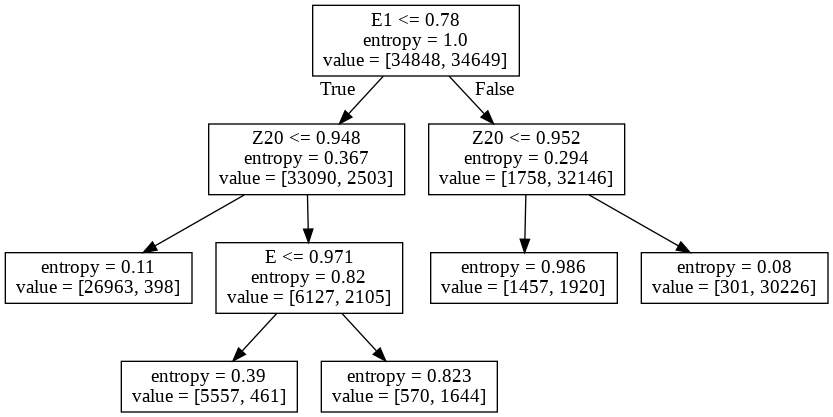

In [ ]:
features = ['Th', 'Ph', 'E', 'NrHits', 'NrBumps', 'E1', 'E1E9', 'E9E25', 'Z20', 'Z53', 'LatMom']
dtc = tree.DecisionTreeClassifier(min_impurity_decrease=0.02, max_depth=None, criterion='entropy')

_ = fitData(train_dataframe, features, dtc, plot_tree=True, val_size=0)

This tree validates our previous analysis. The most relevant parameters are $E_1$, $Z_{20}$ and $E$. We shall not use both $E$ and $E_1$ as stated before. We can try to train our models with $E_9E_{25}$ and NrHits as well to increase accuracy.

## Hyperparameters optimization

### Random forest
The first ML model we train is a Random Forest. We focus on two hyperparameters: the number of trees in the forest and the minimum impurity decrease factor. We begin with relatively small forest of 20 trees to find the best value of min_impurity_decrease. We train models with this parameter in the range (0, 0.003) and we analyse the FOM of both the training and validation set. The Random Forest algorithm implicitly performs a cross-validation.

In [ ]:
features = ['E1', 'LatMom', 'Z20', 'E9E25', 'NrHits']
n_estimator = 20
criterion = 'entropy'
max_depth = None
impurity_list = np.arange(0, 0.003, 0.0001)

rf_results = []
for min_impurity_decrease in impurity_list:
  random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimator, criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
  rf_result, rf_train_fom, rf_val_fom = fitData(train_dataframe, features, random_forest)
  rf_results.append([rf_train_fom, rf_val_fom])   # append the FOMs to the results list
rf_results = np.array(rf_results)                 # convert the list to a numpy array

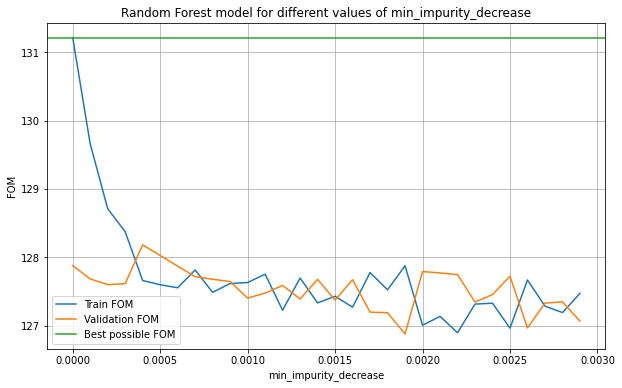

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()
ax.plot(impurity_list, rf_results[:,0], label='Train FOM', color='tab:blue')
ax.plot(impurity_list, rf_results[:,1], label='Validation FOM', color='tab:orange')
ax.axhline(perfect_train_fom, color='tab:green', label='Best possible FOM')
ax.set_xlabel('min_impurity_decrease')
ax.set_ylabel('FOM')
ax.set_title('Random Forest model for different values of min_impurity_decrease')
ax.grid()
ax.legend()

We find the best value of min_impurity_decrease to be around 0.0007. This is chosen as the small possible value before overfitting the model.

We can now try to change the number of trees and see if it makes any difference. We try with forests of 5, 10, 20 and 100 trees.

In [ ]:
features = ['E1', 'LatMom', 'Z20', 'E9E25', 'NrHits']
n_estimators = [5, 10, 20, 100]
criterion = 'entropy'
max_depth = None
min_impurity_decrease = 0.0007

for n_estimator in n_estimators:
  random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimator, criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
  rf_result, rf_train_fom, rf_val_fom = fitData(train_dataframe, features, random_forest, val_size=0.5)
  print('N:', n_estimator, 'Train FOM:', rf_train_fom, 'Val FOM:', rf_val_fom)

N: 5 Train FOM: 127.59720525054828 Val FOM: 127.52668469926367
N: 10 Train FOM: 127.89354455884589 Val FOM: 127.6053727220801
N: 20 Train FOM: 127.40692694728564 Val FOM: 127.70974963827844
N: 100 Train FOM: 127.67416781887164 Val FOM: 127.59923637298014


Using a forest with 100 trees apparently does not get better results than a 10 trees forest. We shall than use 10 trees.

The best parameters are min_impurity_decrease = 0.0007 and n_estimaros = 10. We will use them to perform a cross validation and a test on the test set in the last section.

We cas also test the model with different features. We can try to exclude one feature at a time and see if the FOMs are consistent with our previous analysis of the features we expect to be more relevant.

In [ ]:
features = ['E1', 'LatMom', 'Z20', 'E9E25', 'NrHits']
n_estimators = 10
criterion = 'entropy'
max_depth = None
min_impurity_decrease = 0.0007

for i in range(len(features)):
  features_exclusion = features.copy()
  feature_excluded = features_exclusion.pop(i)
  random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
  # train on all the features except for feature_excluded
  rf_result, rf_train_fom, rf_val_fom = fitData(train_dataframe, features_exclusion, random_forest, val_size=0.5)
  print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('Feature excluded:', feature_excluded, 'Train FOM:', rf_train_fom, 'Val FOM:', rf_val_fom))

random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
rf_result, rf_train_fom, rf_val_fom = fitData(train_dataframe, features, random_forest, val_size=0.5)
print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('No feature excluded:', '', 'Train FOM:', rf_train_fom, 'Val FOM:', rf_val_fom))


Feature excluded: E1       Train FOM: 125.73965089294838   Val FOM: 125.73613483378709
Feature excluded: LatMom   Train FOM: 127.4597621258814   Val FOM: 127.65900797040086
Feature excluded: Z20      Train FOM: 126.63278128596816   Val FOM: 126.63197295791007
Feature excluded: E9E25    Train FOM: 127.82286028658581   Val FOM: 127.39182558224365
Feature excluded: NrHits   Train FOM: 127.30650377479284   Val FOM: 126.7532190913068
No feature excluded:          Train FOM: 127.56003124021984   Val FOM: 127.7320661863474


We can see that we can remove LatMom and E9E25 without altering the result. We can try to remove both and see if this is still true.

In [ ]:
features = ['E1', 'Z20', 'NrHits']
n_estimators = 10
criterion = 'entropy'
max_depth = None
min_impurity_decrease = 0.0007

random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
rf_result, rf_train_fom, rf_val_fom = fitData(train_dataframe, features, random_forest, val_size=0.5)
print('LatMom and E9E25 excluded:', 'Train FOM:', rf_train_fom, 'Val FOM:', rf_val_fom)

LatMom and E9E25 excluded: Train FOM: 127.53454249790413 Val FOM: 127.29418735092868


Even removing all the extra features, and keeping only E1, Z20 and NrHits, the result is almost unaffected. If the computation time is excessive with all the parameters we can use only E1 and Z20.

The model with optimized parameters is tested on the test set in the last section.

### KNN
We can now try to train a KNN. The parameter we are going to optimize is k (the number of neighbours). We are going to try different values of k, in the range (1, 30), trying to minimize the validation fom. To do that we perform a cross validation with 5 repetitions for every value of k.

In [ ]:
features = ['E1_norm', 'Z20_norm', 'E9E25_norm', 'NrHits_norm', 'LatMom_norm']
k_list = np.arange(1, 30, 2)                                      # only using odd values to minimize ties
N = 5                                                             # number of evaluation for every k

knn_results = []
for k in k_list:
  knn = neighbors.KNeighborsClassifier(k)
  train_foms, val_foms = classifierTest(train_dataframe, features, knn, reps=N, val_size=0.5)
  knn_results.append([np.mean(train_foms), np.mean(val_foms)])
knn_results = np.array(knn_results)

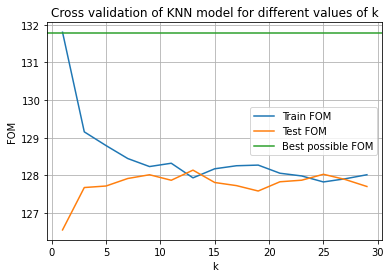

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(k_list, knn_results[:,0], label='Train FOM', color='tab:blue')
ax.plot(k_list, knn_results[:,1], label='Test FOM', color='tab:orange')
ax.axhline(perfect_train_fom, color='tab:green', label='Best possible FOM')
ax.set_xlabel('k')
ax.set_ylabel('FOM')
ax.set_title('Cross validation of KNN model for different values of k')
ax.grid()
ax.legend()

One of the values of k which gives the highest FOM is k=17. It will be used for further development.

We can now try to exclude some features, like we did for the Random Forest.

In [ ]:
features = ['E1', 'LatMom', 'Z20', 'E9E25', 'NrHits']
k = 17
N = 5

knn = neighbors.KNeighborsClassifier(k)

for i in range(len(features)):
  features_exclusion = features.copy()
  feature_excluded = features_exclusion.pop(i)
  knn_train_fom, knn_val_fom = classifierTest(train_dataframe, features_exclusion, knn, val_size=0.5, reps=N)
  print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('Feature excluded:', feature_excluded, 'Train FOM:', np.mean(knn_train_fom), 'Val FOM:', np.mean(knn_val_fom)))

knn_train_fom, knn_val_fom = classifierTest(train_dataframe, features, knn, val_size=0.5, reps=N)
print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('No feature excluded:', '', 'Train FOM:', np.mean(knn_train_fom), 'Val FOM:', np.mean(knn_val_fom)))

Feature excluded: E1       Train FOM: 125.36175748868837   Val FOM: 125.08157839257265
Feature excluded: LatMom   Train FOM: 127.02216806638083   Val FOM: 126.89636329551907
Feature excluded: Z20      Train FOM: 127.00416438942617   Val FOM: 126.58704056402239
Feature excluded: E9E25    Train FOM: 126.90844079637395   Val FOM: 126.86691218803594
Feature excluded: NrHits   Train FOM: 127.36736988678408   Val FOM: 126.90467095420085
No feature excluded:          Train FOM: 126.8877370792784   Val FOM: 127.08672726085702


Like before, we can see that LatMom and E9E25 can be removed without altering the FOM. But in the KNN NrHits plays a marginal role too.  We can now try to remove two of the previous features at the same time and see what happens.

In [ ]:
base_features = ['E1', 'Z20']
extra_features = ['LatMom', 'E9E25', 'NrHits']

k = 17                                      # only using odd values to minimize ties
N = 5                                       # repetitions for cross validation
weights = 'uniform'

knn = neighbors.KNeighborsClassifier(k)

for i in range(len(extra_features)):
  features_total = base_features.copy()
  features_total.append(extra_features[i])
  knn_train_fom, knn_val_fom = classifierTest(train_dataframe, features_total, knn, val_size=0.5, reps=N)
  print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('Extra feature:', extra_features[i], 'Train FOM:', np.mean(knn_train_fom), '\tVal FOM:', np.mean(knn_val_fom)))

knn_train_fom, knn_val_fom = classifierTest(train_dataframe, base_features, knn, val_size=0.5, reps=N)
print('{:>10} {:<8} {:>10} {:>8} {:>10} {:>8}'.format('Base features:', '', 'Train FOM:', np.mean(knn_train_fom), '\tVal FOM:', np.mean(knn_val_fom)))

Extra feature: LatMom   Train FOM: 127.21902318506042  	Val FOM: 126.7357419520154
Extra feature: E9E25    Train FOM: 127.4001856736813  	Val FOM: 127.02772527556968
Extra feature: NrHits   Train FOM: 127.24002560510937  	Val FOM: 126.49421885874615
Base features:          Train FOM: 127.14487333635073  	Val FOM: 126.82491236973404


Even removing all the extra features, and keeping only E1 and Z20, the result is almost unaffected. If the computation time is excessive with all the parameters we can use only E1 and Z20. In order to improve the results, we can add also $E_9E_{25}$.

The model with optimized parameters is tested on the test set in the last section.

### Neural network
We begin by looking for the best neural network layer configuration.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Best FOM for validation set = 128.11230521452916, best FOM for training set = 127.81820456252782
Best hindden layers configuration for training set = 4, 3, 
Best hindden layers configuration for validation set = 4, 2
Test set's FOM: 90.35445682255416


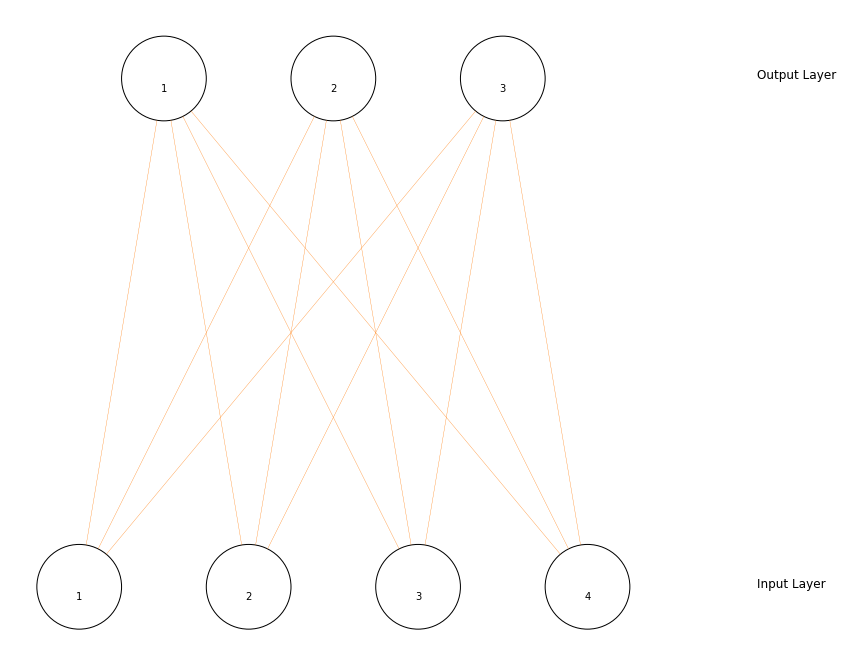

In [ ]:
features_NNe = ['E1_norm', 'LatMom_norm', 'Z20_norm', 'E9E25_norm', 'NrHits_norm']
early_stopping = True
batch_size = 32
activation = 'logistic'
learning_rates = np.arange(0.0001, 1, 0.1)
max_iter = 200

NNe_FOMs_train = {}                                                             #dict which will store FOM for various hidden layers
NNe_FOMs_val = {}

NNe_FOMs_train_best = 0                                                         #initialization of best FOM for train and validation sets, which
NNe_FOMs_val_best = 0                                                           #will further be updated in the loop by the if statement

for i in range(1,5):                                                            #loop through 3 hidden units in the first layer
  for j in range(1,4):                                                          #loop through 2 hidden units in the socond layer. Best FOM
    NNe = neural_network.MLPClassifier(hidden_layer_sizes=(i,j))                #would yield which combination of hidden layers is the best 
    NNe_FOM = fitData(train_dataframe, features_NNe, NNe)
    NNe_FOMs_train[f"H.L. = {i,j}"] = NNe_FOM[1]                                #Storing all FOM values for different hidden layer configuration
    NNe_FOMs_val[f"H.L. = {i,j}"] = NNe_FOM[2]
    if NNe_FOM[2] > NNe_FOMs_train_best:                                        #If statement which updates biggest FOM 
      NNe_FOMs_train_best = NNe_FOM[1]
    if NNe_FOM[1] > NNe_FOMs_val_best:
      NNe_FOMs_val_best = NNe_FOM[2]

print(f"Best FOM for validation set = {NNe_FOMs_val_best}, best FOM for training set = {NNe_FOMs_train_best}")
hidden_layers_train = 0                                                         #Initialization of hidden layers conf. which returns best FOM
hidden_layers_val = 0

for key, value in NNe_FOMs_train.items():                                       #Loop which finds best FOM and corresponding hidden layers
  if value == NNe_FOMs_train_best:                                              #configuration in train and validation sets.
    hidden_layers_train = key[8:12]

for key, value in NNe_FOMs_val.items():
  if value == NNe_FOMs_val_best:
    hidden_layers_val = key[8:12]

print(f"""Best hindden layers configuration for training set = {hidden_layers_train}, 
Best hindden layers configuration for validation set = {hidden_layers_val}""")
network=VisNN.DrawNN([int(hidden_layers_train[0]), int(hidden_layers_train[3])])      #Visualisation of best FOM for training set

NNe_test = neural_network.MLPClassifier(hidden_layer_sizes=(int(hidden_layers_train[0]), int(hidden_layers_train[3])))  #finding best FOM on
fitData(train_dataframe, features_NNe, NNe_test, val_size=0)                                                            #a test set
NNe_test_fom = FOM(NNe_test.predict(test_dataframe[features_NNe]), test_dataframe['Gamma'])
print(f"Test set's FOM: {NNe_test_fom}")


network.draw()

To make sure program doesn't take very long time to run we kept loop through hiden layers relativelly small: 4 at max for first hidden layer and 3 at max for second hidden layer. The best FOM for training set yields close result 131 of the perfect FOM value. The test FOM is also close to the perfect value of 93. Moreover, after multiple runs best possible hidden layers configuration is 4,3 even though from time to time program returns different values. (Of course the upper boundary was 4 for first and 3 for second layers, again in order to run programs in reasonable amount of time)

We can now try to optimize the _learning rate_ parameter.

In [ ]:
features = ['E1_norm', 'LatMom_norm', 'Z20_norm', 'E9E25_norm', 'NrHits_norm']
early_stopping = True
batch_size = 32
activation = 'logistic'
learning_rates = np.arange(0.001, 0.401, 0.05)
max_iter = 50
hidden_layer_sizes=(4,3)
N = 4

NNe_results = []
for learning_rate in learning_rates:
  NNe = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate,
                                     max_iter=max_iter, batch_size=batch_size, early_stopping=early_stopping)
  train_foms, val_foms = classifierTest(train_dataframe, features, NNe, val_size=0.5, reps=N)
  NNe_results.append([np.mean(train_foms), np.mean(val_foms)])
NNe_results = np.array(NNe_results)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


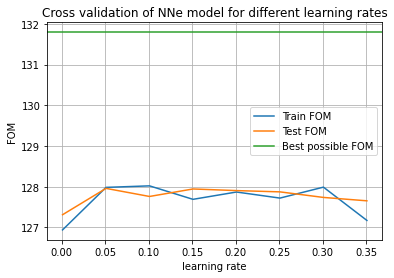

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(learning_rates, NNe_results[:,0], label='Train FOM', color='tab:blue')
ax.plot(learning_rates, NNe_results[:,1], label='Test FOM', color='tab:orange')
ax.axhline(perfect_train_fom, color='tab:green', label='Best possible FOM')
ax.set_xlabel('learning rate')
ax.set_ylabel('FOM')
ax.set_title('Cross validation of NNe model for different learning rates')
ax.grid()
ax.legend()

The best value of the _learning rate_ is found to be around 0.1

## Training and comparison

### Cross validation
Using the best hyperparameters found in the previous sections, we perform a cross validation of all the models. The validation is repeated 20 times. Since we are performing many computations, we only use the most relevent features found in the previous sections. Eventually, we give both the mean and the standard deviation of the FOM for every model.


In [ ]:
# RF parameters
rf_features = ['E1', 'Z20', 'NrHits']                       # since we are training the model 20 times, we use only the most relevant features
n_estimators = 10
criterion = 'entropy'
max_depth = None
min_impurity_decrease = 0.0007

# KNN parameters
knn_features = ['E1_norm', 'Z20_norm']                      # since we are training the model 20 times, we use only the most relevant features
n_neighbors=10
weights='uniform'

#NNe parameters
NNe_features = ['E1_norm', 'LatMom_norm', 'Z20_norm', 'E9E25_norm', 'NrHits_norm']
early_stopping = True
batch_size = 32
activation = 'logistic'
learning_rate = 0.1
max_iter = 50
hidden_layer_sizes=(4,3)

random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                                max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
NNe = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate,
                                   max_iter=max_iter, batch_size=batch_size, early_stopping=early_stopping)

rf_train_foms, rf_val_foms = classifierTest(train_dataframe, rf_features, random_forest, reps=20, val_size=0.5)
knn_train_foms, knn_val_foms = classifierTest(train_dataframe, knn_features, knn, reps=20, val_size=0.5)
NNe_train_foms, NNe_val_foms = classifierTest(train_dataframe, NNe_features, NNe, reps=20, val_size=0.5)

print('Perfect train FOM:', perfect_train_fom)
print('RF FOM:', '\tTrain:', np.mean(rf_train_foms), '+/-', np.std(rf_train_foms), '\tVal:', np.mean(rf_val_foms), '+/-', np.std(rf_val_foms))
print('KNN FOM:', '\tTrain:', np.mean(knn_train_foms), '+/-', np.std(knn_train_foms), '\tVal:', np.mean(knn_val_foms), '+/-', np.std(knn_val_foms))
print('NNe FOM:', '\tTrain:', np.mean(NNe_train_foms), '+/-', np.std(NNe_train_foms), '\tVal:', np.mean(NNe_val_foms), '+/-', np.std(NNe_val_foms))

C:\Users\nicmo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Perfect train FOM: 131.2173768980313
RF FOM: 	Train: 127.431548734231 +/- 0.3330481389837515 	Val: 127.28277075406808 +/- 0.2710518336644315
KNN FOM: 	Train: 126.93963033768202 +/- 0.2852166582830949 	Val: 126.3155858433003 +/- 0.2608091275599202
NNe FOM: 	Train: 127.79951599134492 +/- 0.3358825318546218 	Val: 127.54598502337554 +/- 0.353631879820193


### Test set

In [ ]:
# for the final test we can use all the features, since we have to train the models only once
features = ['E1', 'LatMom', 'Z20', 'E9E25', 'NrHits']
features_norm = [feature + '_norm' for feature in features]

# RF parameters
n_estimators = 10
criterion = 'entropy'
max_depth = None
min_impurity_decrease = 0.0007

# KNN parameters
n_neighbors=10
weights='uniform'

#NNe parameters
early_stopping = True
batch_size = 32
activation = 'logistic'
learning_rate = 0.1
max_iter = 50
hidden_layer_sizes=(4,3)

random_forest = ensemble.RandomForestClassifier(n_estimators=n_estimators, criterion=criterion,
                                                max_depth=max_depth, min_impurity_decrease=min_impurity_decrease)
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
NNe = neural_network.MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, learning_rate_init=learning_rate,
                                   max_iter=max_iter, batch_size=batch_size, early_stopping=early_stopping)

# the models are trained on the whole train set (val_size is then set to 0)
fitData(train_dataframe, features, random_forest, val_size=0)
fitData(train_dataframe, features_norm, knn, val_size=0)
fitData(train_dataframe, features_norm, NNe, val_size=0)


rf_test_fom = FOM(random_forest.predict(test_dataframe[features]), test_dataframe['Gamma'])
knn_test_fom = FOM(knn.predict(test_dataframe[features_norm]), test_dataframe['Gamma'])
NNe_test_fom = FOM(NNe.predict(test_dataframe[features_norm]), test_dataframe['Gamma'])

print('Perfect FOM:\t', perfect_test_fom)
print('RF FOM:\t\t', rf_test_fom)
print('KNN FOM:\t', knn_test_fom)
print('NNe FOM:\t', NNe_test_fom)

Perfect FOM:	 93.86160024205853
RF FOM:		 90.99018653918898
KNN FOM:	 91.03404987058576
NNe FOM:	 91.20533202077095


## Conclusions
We successfully trained three different models. All the models performed better than both a random and a simple classification, based only on the parameter $E$. The resulting FOMs are similar for all the models: we always get a FOM close to 91. The FOM of a perfect classification would be around 93.

The Neural Network Classifier gives slightly better results both on the test and validation sets. The resulting FOMs are still a bit smaller than the perfect case. This means that either some photons are not identified or some neutrons are identified as photons. A small amount of these errors is unavoidable.